# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.250449,False,-1.117088
1,-0.659693,False,-0.972320
2,0.637691,True,7.033255
3,0.518104,True,7.705279
4,0.192020,False,-0.127801
...,...,...,...
995,-0.183314,False,0.057426
996,2.206277,False,3.505940
997,0.885938,False,0.305131
998,-0.461530,True,3.398105


<AxesSubplot:xlabel='v0'>

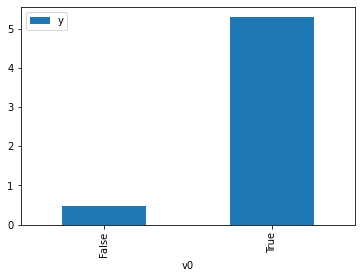

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

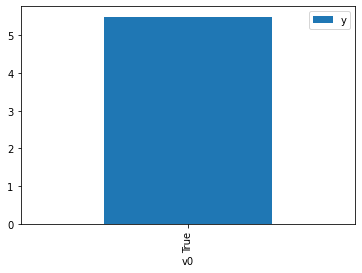

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.292902,False,-0.685664,0.481658,2.076162
1,1.621036,False,0.408193,0.344603,2.901891
2,1.935281,False,4.103593,0.314841,3.176207
3,1.475524,False,2.096591,0.358827,2.786859
4,1.518369,False,3.241588,0.354612,2.819987
...,...,...,...,...,...
995,0.079760,False,-1.485742,0.504496,1.982176
996,0.226452,False,-0.377411,0.488774,2.045934
997,0.266241,False,0.316706,0.484512,2.063931
998,1.079696,False,1.507330,0.398734,2.507941


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.159909,True,6.302796,0.609482,1.640737
1,0.154948,True,6.203229,0.503563,1.985848
2,1.530914,True,7.041628,0.646619,1.546507
3,-0.516360,True,5.628885,0.432030,2.314657
4,0.822897,True,7.071245,0.574599,1.740344
...,...,...,...,...,...
995,-0.933176,True,2.373203,0.388817,2.571906
996,0.518104,True,7.705279,0.542388,1.843700
997,0.262007,True,5.504281,0.515034,1.941619
998,-1.013483,True,3.397072,0.380666,2.626972


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              9054.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        11:03:13   Log-Likelihood:                         -1461.7
No. Observations:                1000   AIC:                                      2927.
Df Residuals:                     998   BIC:                                      2937.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6500      0.035     47.574      0.000       1.582       1.718
x2             4.8973      0.049     99.611      0.000       4.801       4.994
==============================================================================
Omnibus:                        1.868   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.934
Skew:                           0.087   Prob(JB):                        0.380
Kurtosis:                       2.873   Cond. No.                         1.69
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""